In [1]:
__maintainer__ = "[José M. Beltrán](<jobel.open.science@gmail.com>)"
__modified_from = {"code":"matlab","credits":"Shungudzemwoyo Garaba","email":"<shungu.garaba@uni-oldenburg.de>", "dates":{"created":20110224, "modified":20140910}}
__credits__ = ["José M. Beltrán"]
__license__ = "GPL-3.0"
__status__ = []

# Notebook to calculate the Forel-Ule Index

**Reference** :
Wernand, M. R., Hommersom, a., & Van Der Woerd, H. J. (2013). MERIS-based ocean colour classification with the discrete Forel-Ule scale. Ocean Science, 9, 477–487. doi:10.5194/os-9-477-2013

**Bibtex** : 
@article{Wernand2013, 
author = {Wernand, M. R. and Hommersom, a. and {Van Der Woerd}, H. J.}, 
title = {{MERIS-based ocean colour classification with the discrete Forel-Ule scale}},
doi = {10.5194/os-9-477-2013},
issn = {18120784},
journal = {Ocean Science},
pages = {477--487},
volume = {9},
year = {2013}
}

In [2]:
# Keeping a local mathjax for Latex rendering
from IPython.external import mathjax  #mathjax.install_mathjax()

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr

In [4]:
# Set the current working directory
#os.chdir('/home/jobel/gits/jobel/FUME')

[**Notes from the colour and vision research laboratory**](http://www.cvrl.org/)

The CIE 1931 2-deg CMFs (CIE, 1932), which form the basis for most practical colorimetry, are based on the chromaticity coordinates obtained by Guild (1931) and by Wright (1928). Chromaticity coordinates, however, provide only a relative measure of the ratios of the three primaries needed to match each spectrum color, whereas CMFs specify absolute energy values. In order to reconstruct the CMFs from the Wright and Guild data, it was assumed that the CIE1924 V(l) photopic luminosity function (CIE, 1926) is a linear combination of the three CMFs (see Wyszecki & Stiles, 1982), for a description of the reconstruction and for the tabulated values. 

It has long been clear that the CIE1924 V(λ) that was used to construct the CIE 1931 2-deg CMFs **seriously underestimates sensitivity at wavelengths below 460 nm**, so that these CMFs are seriously in error at short wavelengths. The Judd and Judd-Vos modifications are attempts to overcome this problem.


In [5]:
cmf = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_CIE1931_JV.tsv")
fui = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_ATAN210.tsv", names = ["value", "atan"])

In [6]:
cmf

,wavelength,x,y,z
0,380,0.002690,2.000000e-04,1.226000e-02
1,385,0.005311,3.955600e-04,2.422200e-02
2,390,0.010781,8.000000e-04,4.925000e-02
3,395,0.020792,1.545700e-03,9.513500e-02
4,400,0.037981,2.800000e-03,1.740900e-01
...,...,...,...,...
85,805,0.000007,2.607600e-06,5.862600e-10
86,810,0.000005,1.836500e-06,4.213800e-10
87,815,0.000003,1.295000e-06,3.031900e-10
88,820,0.000002,9.109200e-07,2.175300e-10


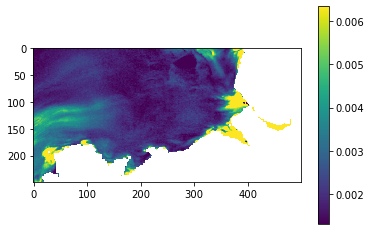

In [7]:
# load test dataset
ds = xr.open_dataset('data/S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.polymer.LivBay.nc')
plt.imshow(ds['Rw665'],
           vmin=ds['Rw665'].quantile(0.05),
           vmax=ds['Rw665'].quantile(0.95))
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


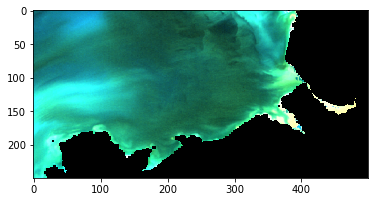

In [8]:
rgb = xr.concat([ds['Rw665'],ds['Rw560'],ds['Rw490']],dim='rgb').transpose('height','width','rgb')
plt.imshow(rgb/rgb.quantile(0.95))

In [9]:
# Extract wavelengths from band names
wavelength = []
bandid = []
reflectance_name = 'Rw'
for var in ds.data_vars:
    if reflectance_name in var:
        bandid.append(var)
        wavelength.append( int ( var.replace(reflectance_name,'') ) )

# Create a 3-D array along wavelength dimension
Rw = xr.concat( [ds[id] for id in bandid] ,dim='wavelength')
Rw.name = 'Rw'
Rw = Rw.assign_coords(wavelength=wavelength)

wavelength overlintersection 400 779
xi1 range(400, 779, 5)


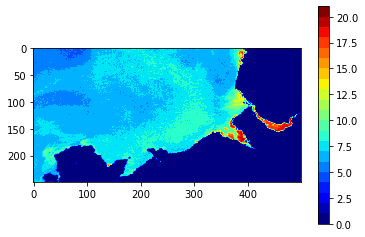

In [11]:
def calc_ForelUle(wavelength, reflectance, cmf):
    
    Delta = cmf['wavelength'][1] - cmf['wavelength'][0]
    
    # find overping wavlengths between cmf and multispectral image 
    start = max([cmf['wavelength'].iloc[0], wavelength.min()])
    end = min([cmf['wavelength'].iloc[-1], wavelength.max()])
    print('wavelength overlintersection', start,end)
    cmfi = cmf[ (cmf['wavelength'] >= start) & (cmf['wavelength'] <= end) ]
        
    cmfi = {"wavelength": cmfi['wavelength'],
            "x": np.reshape( cmfi['x'].values, [len(cmfi['x']),1,1] ),
            "y": np.reshape( cmfi['y'].values, [len(cmfi['y']),1,1] ),
            "z": np.reshape( cmfi['z'].values, [len(cmfi['z']),1,1] )}
    
    xi1 = range( start, end, Delta)
    print('xi1',xi1)
    int_r1 = interp1d( wavelength, reflectance, axis = 0, kind = 'linear')(cmfi['wavelength'].values)
    
    # Creating a dictionary to hold the reflectance values aas tristimulus
    r = {"x": [], "y": [], "z": []}
    
    r["x"] = int_r1 * cmfi["x"]
    r["y"] = int_r1 * cmfi["y"]
    r["z"] = int_r1 * cmfi["z"]
    

    # ------ Sum
    s = {"x": [], "y": [], "z": []}

    s["x"] = sum(r["x"] * Delta)
    s["y"] = sum(r["y"] * Delta)
    s["z"] = sum(r["z"] * Delta)
        
    sum_xyz = s["x"] + s["y"] + s["z"]
    
    # ------ chromaticity
    chrom = {"x": [], "y": [], "z": []}
    chrom["x"] = sum(r["x"] * Delta) / sum_xyz
    chrom["y"] = sum(r["y"] * Delta) / sum_xyz
    chrom["z"] = sum(r["z"] * Delta) / sum_xyz

    sum_chrom_y = chrom["x"] + chrom["y"] + chrom["z"]

    # ______ chromaticity - whiteness
    chrom_w = {"x": [], "y": []}
    chrom_w["x"] = chrom["x"] - (1 / 3)
    chrom_w["y"] = chrom["y"] - (1 / 3)

    # ______ calculate atan2
    # we use the average atan per scale
    a_i = np.arctan2( chrom_w["y"], chrom_w["x"]) * 180 / math.pi

    a_i[a_i < 0] =  a_i[a_i < 0] + 360
        
    # ----- fui approximation
    fu_i = np.zeros(a_i.shape)
    fu_i[ a_i >= fui["atan"][0]] = 1   #FUI = 1 its > Average
    fu_i[ np.isnan(a_i) ] = 0           # FUI = NAN = 0
    fu_i[ a_i <= fui["atan"].iloc[-1]] = 21  #FUI = 1 its > Average
    
    for c in range(0, len(fui)-1):
        fu_i[ (a_i <= fui["atan"].iloc[c]) & (a_i > fui["atan"].iloc[c+1]) ] = fui['value'].iloc[c]            
    return fu_i


fu_i = calc_ForelUle(Rw.coords['wavelength'].values, Rw, cmf)
plt.imshow(fu_i, cmap=cm.get_cmap('jet', 21))
plt.colorbar()